In [104]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from os import listdir
from os.path import join

sys.path.append('../')
sys.path.insert(0, '../src')

from etl import generate_labels

# Introduction

Given a time period of data about what packets are being sent through a conversation between these devices, we attempt to recover and predict the packet loss ratio (how many packets are not received per amount of packets sent) and latency (how long it takes for information to reach the recipient). 

Packet loss and latency are two of the many variables that affect the quality of an internet connection. This model could assist in determining which aspects of the network need improvement and can give insight into developing a better product. 

## Methods

Using the features listed below:


In [105]:
loss_features = [
    "mean_tdelta_min",
    "mean_tdelta_max",
    "mean_tdelta_mean",
    "max_tdelta_var",
    "1->2Bytes_var",
    "2->1Bytes_var",
    "1->2Pkts_var",
    "2->1Bytes_var",
    "1->2Pkts_rolling_2s_mean_var",
    "2->1Pkts_rolling_2s_mean_var",
    "1->2Pkts_rolling_3s_mean_var",
    "2->1Pkts_rolling_3s_mean_var",
]

latency_features = [
    '1->2Pkts_rolling_3s_mean_sum',
    '1->2Pkts_rolling_3s_mean_std',
    '2->1Pkts_rolling_2s_mean_min',
    '1->2Pkts_rolling_3s_mean_min',
    'label_packet_loss',
    '1->2Pkts_std',
    '1->2Pkts_rolling_2s_mean_min',
    '1->2Bytes_median',
    '2->1Bytes_max',
    '2->1Pkts_rolling_3s_mean_std',
    'label_latency',
    '2->1Bytes_mean',
    '2->1Pkts_median',
    '2->1Pkts_rolling_3s_mean_sum',
    '1->2Bytes_std',
    'pred_loss',
    '1->2_interpacket_mean',
    '2->1Pkts_rolling_2s_mean_max',
    'max_tdelta_max',
    '2->1Pkts_min',
    '1->2Bytes_max',
    '2->1Bytes_median',
    '1->2Pkts_max',
    '1->2Pkts_rolling_2s_mean_sum',
    '1->2Pkts_rolling_3s_mean_max',
    '2->1Pkts_rolling_2s_mean_std',
    'mean_tdelta_var',
    '2->1Pkts_rolling_2s_mean_sum',
    '2->1Pkts_sum',
    '2->1Pkts_mean',
    '2->1Pkts_std',
    '2->1Pkts_var',
    '1->2Pkts_median',
    'mean_tdelta_std',
    '2->1Pkts_rolling_3s_mean_max',
    '1->2Bytes_mean',
    'max_tdelta_mean',
    '1->2Pkts_min',
    '2->1Bytes_std',
    '2->1Bytes_min',
    '1->2Pkts_rolling_2s_mean_max',
    '2->1Pkts_max',
    '2->1Pkts_rolling_3s_mean_min',
    '1->2Pkts_mean',
    'max_tdelta_std',
    '2->1_interpacket_mean',
    '1->2Pkts_sum',
    '1->2Pkts_rolling_2s_mean_std',
    '1->2Bytes_min'
]

In [106]:
# list(set(data.columns) - set(loss_features))

In [122]:
## training data
data_path = '../data/out'
featurelst = listdir(data_path)
featurelst.sort()
data = pd.read_csv(join(data_path,'0_train_out.csv'))
loss_X = data[loss_features]
loss_y = np.log(data['label_packet_loss']) #log loss

vdata = pd.read_csv(join(data_path,'0_validation_out.csv'))
loss_Xv = vdata[loss_features]
loss_yv = np.log(vdata['label_packet_loss']) #log loss

## test data
test = pd.read_csv('../test/test_features/test_featureset.csv')
loss_test_X = test[loss_features]
loss_test_y = np.log(test['label_packet_loss']) #log loss

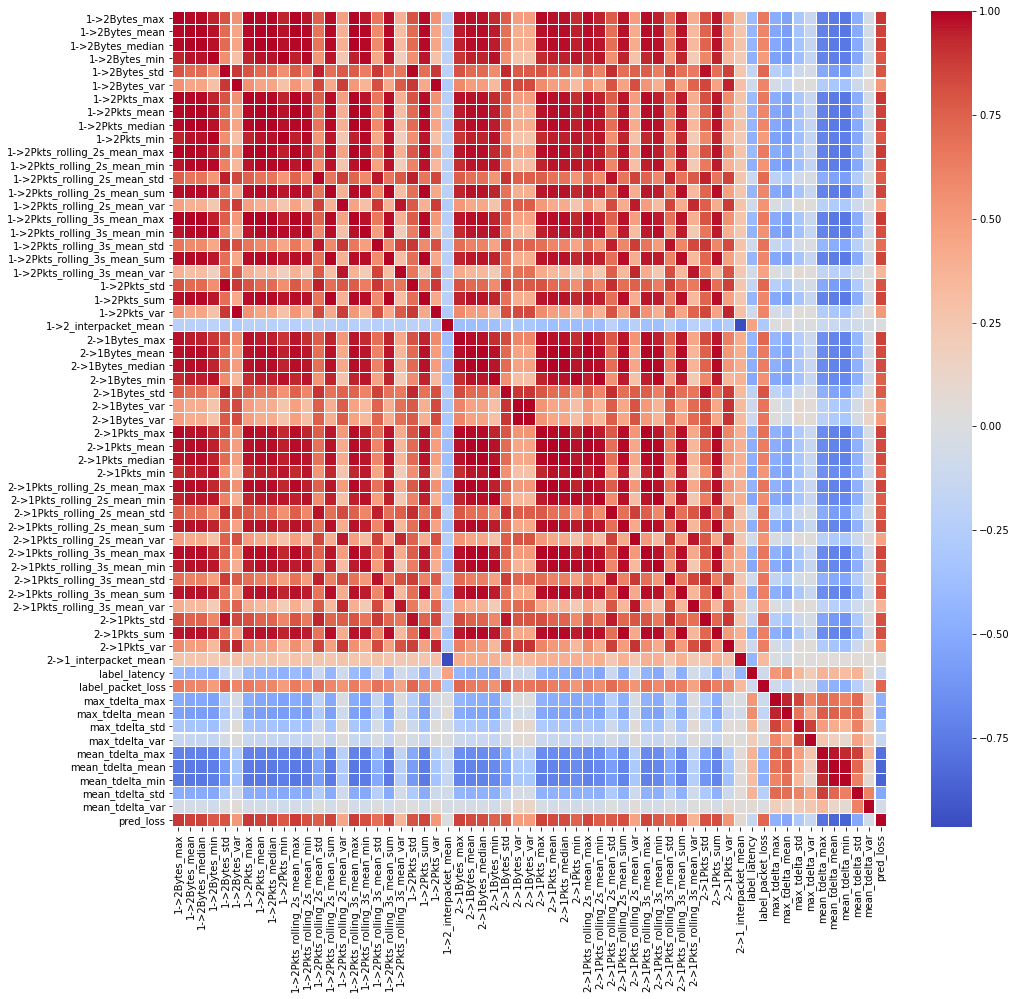

In [120]:
plt.figure(figsize=(16,15))

# sns.heatmap(features_label.loc[features_label["label_latency"] <= 500].corr(), cmap="coolwarm",linewidths=.05);
sns.heatmap(data[sorted(loss_features+latency_features)].corr(), cmap="coolwarm",linewidths=.05);

### The final model:

#### Loss Model

In [108]:
# this assumes you have run the etl/data, features, and train targets
loss_model = pickle.load(open('../models/loss_model.pyc', 'rb'))
latency_model = pickle.load(open('../models/latency_model.pyc', 'rb'))
latency_model

Pipeline(steps=[('impute', SimpleImputer()),
                ('reduce_dim', PCA(n_components=20)),
                ('clf',
                 RandomForestRegressor(max_depth=15, n_estimators=500,
                                       n_jobs=-1))])

In [109]:
loss_model.score(loss_X, loss_y)
loss_model.score(loss_test_X, loss_test_y)

0.5007670443839595

In [126]:
upper = .15
lower = 0
step = .0025
thresh_l = [i*step for i in range(int((upper-lower) / step))]

def get_acc(target, pred, thresh):
    latency_diff = (target - pred) / target
    return sum(abs(latency_diff) <= thresh) / len(target)

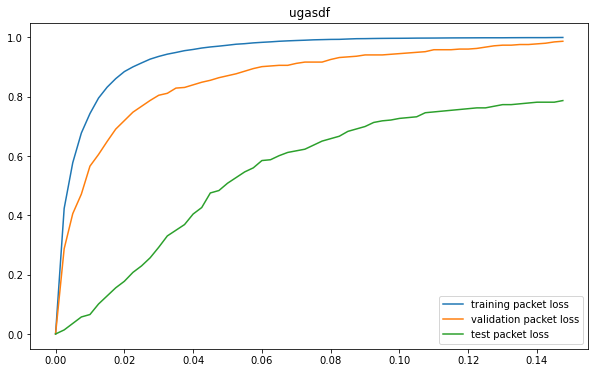

In [141]:
plt.figure(figsize=(10,6))
loss_yhat = loss_model.predict(loss_X)
loss_valid_yhat = loss_model.predict(loss_Xv)
loss_test_yhat = loss_model.predict(loss_test_X)

loss_acc = [0 for i in range(int((upper-lower) / step))]
loss_valid_acc = [0 for i in range(int((upper-lower) / step))]
loss_test_acc = [0 for i in range(int((upper-lower) / step))]
for i in range(len(thresh_l)):
    loss_acc[i] += get_acc(loss_y, loss_yhat, thresh_l[i])
    loss_valid_acc[i] = get_acc(loss_yv, loss_valid_yhat, thresh_l[i])
    loss_test_acc[i] = get_acc(loss_test_y, loss_test_yhat, thresh_l[i])
plt.plot(thresh_l, loss_acc, label='training packet loss')
plt.plot(thresh_l, loss_valid_acc, label='validation packet loss')
plt.plot(thresh_l, loss_test_acc, label='test packet loss')
plt.title('ugasdf')
plt.legend()

#### Latency Model

In [130]:
data['pred_loss'] = loss_yhat
latency_X = data[latency_features]
latency_y = np.log(data['label_latency'])

vdata['pred_loss'] = loss_valid_yhat
latency_Xv = vdata[latency_features]
latency_yv = np.log(vdata['label_latency'])

## test data
test['pred_loss'] = loss_test_yhat
latency_test_X = test[latency_features]
latency_test_y = np.log(test['label_latency'])

In [131]:
latency_model.score(latency_X, latency_y)

-0.5336882234445226

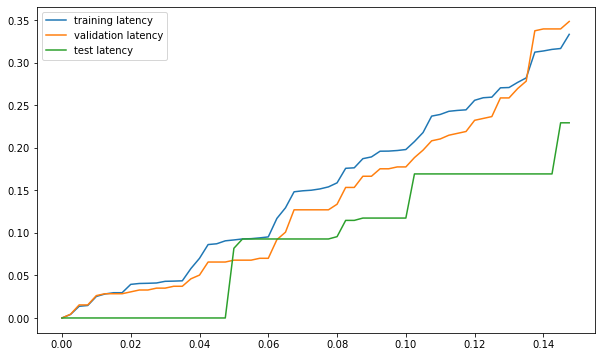

In [138]:
plt.figure(figsize=(10,6))
latency_yhat = latency_model.predict(latency_X)
latency_valid_yhat = latency_model.predict(latency_Xv)
latency_test_yhat = latency_model.predict(latency_test_X)

latency_acc = [0 for i in range(int((upper-lower) / step))]
latency_valid_acc = [0 for i in range(int((upper-lower) / step))]
latency_test_acc = [0 for i in range(int((upper-lower) / step))]
for i in range(len(thresh_l)):
    latency_acc[i] += get_acc(latency_y, latency_yhat, thresh_l[i])
    latency_valid_acc[i] = get_acc(latency_yv, latency_valid_yhat, thresh_l[i])
    latency_test_acc[i] = get_acc(latency_test_y, latency_test_yhat, thresh_l[i])
plt.plot(thresh_l, latency_acc, label='training latency')
plt.plot(thresh_l, latency_valid_acc, label='validation latency')
plt.plot(thresh_l, latency_test_acc, label='test latency')
plt.legend()

In [115]:
pd.Series(loss_model.named_steps.clf.feature_importances_, index=loss_features).sort_values(ascending=False)

1->2Pkts_rolling_2s_mean_var    0.618172
1->2Pkts_var                    0.119669
1->2Bytes_var                   0.104424
2->1Bytes_var                   0.035621
2->1Bytes_var                   0.034529
mean_tdelta_min                 0.017022
2->1Pkts_rolling_2s_mean_var    0.016935
mean_tdelta_max                 0.015688
mean_tdelta_mean                0.012502
1->2Pkts_rolling_3s_mean_var    0.010167
max_tdelta_var                  0.008696
2->1Pkts_rolling_3s_mean_var    0.006574
dtype: float64

In [116]:
pd.Series(latency_model.named_steps.clf.feature_importances_).sort_values(ascending=False)

3     0.545862
1     0.129629
14    0.100771
16    0.036580
6     0.034866
17    0.031610
13    0.029118
0     0.023607
7     0.022245
2     0.012192
18    0.010323
12    0.004228
19    0.004003
11    0.002582
8     0.002470
9     0.002384
4     0.002029
15    0.002015
10    0.001898
5     0.001590
dtype: float64

In [1]:
string = '123456'
'34' in string

True